In [1]:
#!pip install -i https://mirrors.ustc.edu.cn/pypi/web/simple pandas stop-words nltk beautifulsoup4
import pandas as pd

df = pd.read_csv('./Bitcoin_tweets.csv', usecols=['text', 'date'])
df.head()

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple


/tmp/ipykernel_348/80906082.py:4: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./Bitcoin_tweets.csv', usecols=['text', 'date'])


date                                               text
0  2021-02-10 23:59:04  Blue Ridge Bank shares halted by NYSE after #b...
1  2021-02-10 23:58:48  😎 Today, that's this #Thursday, we will do a "...
2  2021-02-10 23:54:48  Guys evening, I have read this article about B...
3  2021-02-10 23:54:33  $BTC A big chance in a billion! Price: \487264...
4  2021-02-10 23:54:06  This network is secured by 9 508 nodes as of t...

In [2]:
def test(x):
    if not isinstance(x, str):
        return 0
    t = x.split('-')[0]
    if not t.isdigit():
        return 0
    return int(t)
    
df['date2'] = df['date'].apply(test)
df = df.query('date2>=2018')
df.head()

date                                               text  \
0  2021-02-10 23:59:04  Blue Ridge Bank shares halted by NYSE after #b...   
1  2021-02-10 23:58:48  😎 Today, that's this #Thursday, we will do a "...   
2  2021-02-10 23:54:48  Guys evening, I have read this article about B...   
3  2021-02-10 23:54:33  $BTC A big chance in a billion! Price: \487264...   
4  2021-02-10 23:54:06  This network is secured by 9 508 nodes as of t...   

   date2  
0   2021  
1   2021  
2   2021  
3   2021  
4   2021

In [3]:
df = df[['date2', 'text']]

In [4]:
import re

from bs4 import BeautifulSoup
from stop_words import get_stop_words
from nltk import SnowballStemmer


english_stop_words = get_stop_words('english')  # 获取英语的停用词
snowball_stem = SnowballStemmer('english')  


def remove_html(text):  # 删除html内容，比如<div>
    bs = BeautifulSoup(text, "html.parser")  # 使用beautifulsoup去除
    return ' ' + bs.get_text() + ' '

def remove_stop_words(text):  # 删除停用词
    for stopword in english_stop_words:
        stopword = ' ' + stopword + ' '
        text = text.replace(stopword, ' ')  # 替换停用词
    return text


def remove_symbol(text):  # 去除所有标点符号
    text = re.sub(r'[^\w\s]', ' ', text)  # 使用正则去除标点
    return text
    

def remove_special_symbol(text):
    text = re.sub('@\\w+ *', '', text, flags=re.MULTILINE)  # 去除@用户
    text = text.replace('\n', ' ').replace('\r', ' ')  # 去除换行符
    text = re.sub('["\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF"]', '', text)  # 去除emoji表情
    return text

def word_stemming(text):
    return ' '.join([snowball_stem.stem(row) for row in text.split() if row])  # 转为相同词


def clean_reviews(text):  # 清除上面列举的这些
    text = remove_html(text)
    text = remove_stop_words(text)
    text = remove_symbol(text)
    text = remove_special_symbol(text)
    text = word_stemming(text)
    return text

df['text'] = df['text'].apply(clean_reviews)
df.head()


/opt/conda/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


date2                                               text
0   2021  blue ridg bank share halt nyse bitcoin atm ann...
1   2021  today thursday will take 2 friend leowandersle...
2   2021  guy even i read articl btc like share https t ...
3   2021  btc a big chanc billion price 4872644 0 2021 0...
4   2021  this network secur 9 508 node today soon bigge...

In [6]:
!pip install textblob -i https://mirrors.ustc.edu.cn/pypi/web/simple
!pip install vaderSentiment -i https://mirrors.ustc.edu.cn/pypi/web/simple

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def sentiment(x):
    sentiment = TextBlob(x)  # 使用 TextBlob 给文本打分， 分数在[-1, 1]之间
    return sentiment.sentiment.polarity


def sentiment_vader(x):
    sentiment = SentimentIntensityAnalyzer()  # 使用 vader给文本打分，分数也是在[-1, 1]之间
    return sentiment.polarity_scores(x)['compound']


df['textblob'] = df['text'].apply(sentiment)  # 每一行的 Text都去打分（TextBlob）
df['vader'] = df['text'].apply(sentiment)  # 每一行的 Text都去打分 (Vader)
df.head()

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple
     |████████████████████████████████| 636 kB 731 kB/s            
Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple
     |████████████████████████████████| 125 kB 642 kB/s            


date2                                               text  textblob  vader
0   2021  blue ridg bank share halt nyse bitcoin atm ann...      0.00   0.00
1   2021  today thursday will take 2 friend leowandersle...      0.00   0.00
2   2021  guy even i read articl btc like share https t ...      0.00   0.00
3   2021  btc a big chanc billion price 4872644 0 2021 0...      0.00   0.00
4   2021  this network secur 9 508 node today soon bigge...     -0.25  -0.25

In [7]:
def score_mark(score):  # 这里是把分数转为文字
    if score > 0:
        return 'positive'
    elif score == 0:
        return 'neutral'
    else:
        return 'negative'

df['tb_mark'] = df['textblob'].apply(score_mark)  # 每一行的 textblob 都去转换
df['vader_mark'] = df['vader'].apply(score_mark)  # 同上

df.head()

date2                                               text  textblob  vader  \
0   2021  blue ridg bank share halt nyse bitcoin atm ann...      0.00   0.00   
1   2021  today thursday will take 2 friend leowandersle...      0.00   0.00   
2   2021  guy even i read articl btc like share https t ...      0.00   0.00   
3   2021  btc a big chanc billion price 4872644 0 2021 0...      0.00   0.00   
4   2021  this network secur 9 508 node today soon bigge...     -0.25  -0.25   

    tb_mark vader_mark  
0   neutral    neutral  
1   neutral    neutral  
2   neutral    neutral  
3   neutral    neutral  
4  negative   negative

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple
     |████████████████████████████████| 11.8 MB 338 kB/s            
     |████████████████████████████████| 3.3 MB 15.6 MB/s            
     |████████████████████████████████| 296 kB 6.2 MB/s            
     |████████████████████████████████| 1.6 MB 13.3 MB/s            
     |████████████████████████████████| 965 kB 14.0 MB/s            
mark      negative    neutral   positive
TextBlob  531500.0  2234680.0  1819291.0
Vader     531500.0  2234680.0  1819291.0
Combined  531500.0  2234680.0  1819291.0


<AxesSubplot: >

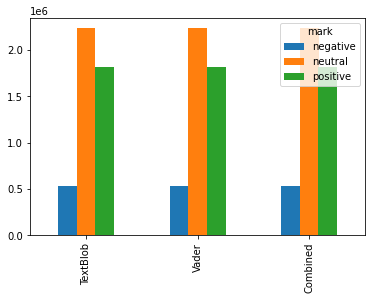

In [9]:
!pip install matplotlib -i https://mirrors.ustc.edu.cn/pypi/web/simple
tmp_df = df[['tb_mark', 'vader_mark']]  # 选出 'tb_mark', 'vader_mark' 这两列
tmp_df1 = tmp_df.groupby('tb_mark', as_index=False).size().reset_index()  # 分组求count
tmp_df2 = tmp_df.groupby('vader_mark', as_index=False).size().reset_index()  # 分组 求count
tmp_df1 = tmp_df1[['tb_mark', 'size']]  # 这是选出这两列
tmp_df2 = tmp_df2[['vader_mark', 'size']]    # 这是选出这两列
tmp_df1.columns = ['mark', 'TextBlob']  # 重新设置列名
tmp_df2.columns = ['mark', 'Vader']  # 重新设置列名


tmp_df3 = pd.merge(tmp_df1, tmp_df2, on='mark')  # 合并两个 Dataframe
tmp_df3['Combined'] = (tmp_df3['TextBlob'] + tmp_df3['Vader']) / 2  # 新增一列，这一列的数据是根据另外两列计算出来
tmp_df3 = tmp_df3.set_index('mark')  # 设置索引
print(tmp_df3.T)  # 转置
tmp_df3.T.plot.bar()  # 转置画图